In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. 

In [2]:
MASK_DIR = "data/mask_image"
DATA_DIR="data/fish_image"
IMG_SIZE = 100
LR = 1e-3

MODEL_NAME = 'fishCNN_oct_parallel-{}-{}.model'.format(LR, '2conv-basic')

def createData():
    data=[]
    mask=[]
    for dir in tqdm(os.listdir(DATA_DIR)):
        mask_path = os.path.join(MASK_DIR,dir)
        img_path=os.path.join(DATA_DIR,dir)
        label=dir.split('_')[-1];
        oneHotLabel=np.zeros(23);
        oneHotLabel[int(label)-1]=1;
        for img in tqdm(os.listdir(img_path)):
            path = os.path.join(img_path,img)
            imgData = cv2.imread(path)
            imgData = cv2.resize(imgData, (IMG_SIZE,IMG_SIZE))
            
            
            mpath = os.path.join(mask_path,img)
            mpath=mpath.replace("fish","mask")
            mask= cv2.imread(mpath,cv2.IMREAD_GRAYSCALE)
            
#             print mpath
#             print mask.shape
            mask=cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
            
            imgData=np.dstack((imgData,mask))
            
            data.append([np.array(imgData),np.array(oneHotLabel)])
            
    shuffle(data)
    np.save('data_masked_parallel.npy', data)
    return data

In [3]:
#data=createData()
data=np.load("data_masked_parallel.npy")

In [4]:
data[0][0].shape

(100, 100, 4)

In [5]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 4], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 23, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log_mask')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [6]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /home/sushant/ml/FISHES PROJECT/sj/fishCNN_oct_parallel-0.001-2conv-basic.model
model loaded!


In [7]:
train = data[:-int(len(data)/20)]
test = data[-int(len(data)/20):]


In [8]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
test_y = [i[1] for i in test]

#X.dtype

# X=X.view('float32')
# test_x/=test_x.view('float32')

# test_x
test_x.size

54720000

In [ ]:
#model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [ ]:
#model.save(MODEL_NAME)



In [9]:
X[1,:,:,0:3].shape


(100, 100, 3)

In [10]:
cv2.imshow('fish',X[1,:,:,1:4])

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

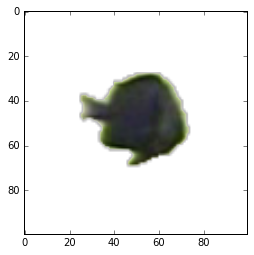

[[  9.97758985e-01   8.94077311e-05   1.97486923e-04   2.16738158e-06
    3.60140712e-06   7.63802018e-06   6.66642652e-09   6.09028735e-04
    7.13163972e-09   1.08836690e-11   6.38470521e-09   2.60836191e-06
    5.73998800e-11   1.19563274e-03   5.90177422e-07   1.13742019e-11
    6.13696471e-08   7.99306871e-11   4.33621040e-07   1.55346001e-07
    3.28660935e-05   9.92548521e-05   4.08217210e-11]]
[[ 0 13  7  2 21  1 20  5  4 11  3 14 18 19 16  8  6 10 17 12 22 15  9]]


In [59]:
n=117

plt.imshow(test_x[n,:,:,0:4])
plt.show()
print model.predict([test_x[n]])
print model.predict_label([test_x[n]])

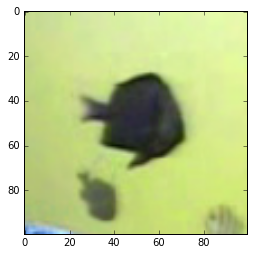

In [60]:
plt.imshow(test_x[n,:,:,0:3])